In [1]:
from cytoflow import *
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit
import math

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['pdf.fonttype'] = 42
sns.set_style("ticks", { "xtick.major.size": 4, "ytick.major.size": 4, "font_color":'k', 'axes.edgecolor': 'k', 'xtick.color': 'k', 'ytick.color': 'k'})
sns.set_context("talk", font_scale=1.0)

In [2]:
plasmids = [74, 75, 76, 77, 78, 79, 
            80, 81, 82, 83, 84, 87,
            90, 91, 92, 93, 94, 96,
            97, 98, 99, 126, 217, 144]

In [3]:
plasmid_dict = { # maps plasmid number => plasmid name
#     57 : "ZIK1 KRAB + ZNF10 KRAB",    58 : "ZIK1 KRAB + FOXO3 TAD",
    59 : "ZIK1 KRAB + Rand Ctrl 89",  #60 : "KMT2C Dual + ZNF10 KRAB",
    61 : "KMT2C Dual + FOXO3 TAD",    #62 : "KMT2C Dual + Rand Ctrl 89",
    63 : "KMT2D Dual + ZNF10 KRAB",   #64 : "KMT2D Dual + FOXO3 TAD",
    65 : "KMT2D Dual + Rand Ctrl 89", 66 : "NCOA1 Dual + ZNF10 KRAB",
    67 : "NCOA1 Dual + FOXO3 TAD",    68 : "NCOA1 Dual + Rand Ctrl 89",
    69 : "NCOA2 Rep + FOXO3 TAD",     #70 : "Rand Ctrl + NCOA2 Act",
    #71 : "NCOA2 Rep + NCOA2 Act",     
    72 : "Rand Ctrl + Rand Ctrl 89",
    
    74 : "DMD - DMD",     75 : "DMD - RANDCTRL",      76 : "ZNF10 - ANM2",
    77 : "ZNF10 - CBX1",  78 : "RANDCTRL - RANDCTRL", 79 : "ANM2 - KIBRA",
    80 : "BIN1 - FOXO3",  81 : "CACO1 - ANM2",        82 : "CREM - MPP8",
    83 : "DPF1 - HSF2",   84 : "DPY30 - HXA13",       #85 : "FOXO3 - ZNF10",
    #86 : "IKKA - ANM2",   
    87 : "MPP8 - ZNF791", #88 : "MYBA - FOXO3",
    #89 : "NCOA2 - HXA13", 
    90 : "NOTC2 - ANM2",        91 : "NOTC2 - KIBRA",
    92 : "SMCA2 - U2AF4", 93 : "SUMO3 - SSX2",        94 : "YAF2 - ZNF791",
    #95 : "HES2 - NCOA2",  
    96 : "ATRX - HERC2",        97 : "SCML2 - NOTC2",
    98 : "CHD4 - CDYL2",  99 : "SMN2 - FOXO3",       
    
    126 : "rTetR only",  217 : "KRAB only",          144 : "MYBA only"
}

In [4]:
df = pd.read_csv('./data/all_cells_live_mch_gated.csv')
df = df[(df['P1'])&(df['mCherry'])]
df

,FSC 488/10-A,SSC 488/10-A,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,treatment,P1,mCherry
0,8.317540e+08,219492864.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,14387968.0,85923072.0,59,1.0,none,True,True
1,4.958666e+08,180896512.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,104767232.0,66599936.0,59,1.0,none,True,True
2,4.226458e+08,101837056.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,26209536.0,61377280.0,59,1.0,none,True,True
3,1.038254e+09,372244224.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,365425920.0,376630272.0,59,1.0,none,True,True
4,8.091105e+08,349765120.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,180713472.0,1863680.0,59,1.0,none,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
42598448,8.930967e+08,375278592.0,20.0,MYB only,1000.0,56984320.0,3530240.0,144,2.0,none,True,True
42598449,3.344148e+08,232225536.0,20.0,MYB only,1000.0,19082240.0,2760960.0,144,2.0,none,True,True
42598450,6.809889e+08,270729216.0,20.0,MYB only,1000.0,179726848.0,34354432.0,144,2.0,none,True,True
42598451,7.104010e+08,199698432.0,20.0,MYB only,1000.0,231051776.0,30063872.0,144,2.0,none,True,True


In [5]:
# drop plasmid 67 
df = df[df['plasmid'] != 67]

In [6]:
def get_citrine_threshold(day):
    # return mean + 2 SDs of pJT126
    data = df[df['day']==day]
    data = data[data['plasmid']==126]
    data = data[data['treatment']=='none']
    data = data[data['dox']==0]
    logd = np.log10(list(data['mCitrine-A'])) # get log data
    
    gm = GaussianMixture(n_components = 2).fit(logd.reshape(-1,1))
    
    m0 = gm.means_[0][0]
    m1 = gm.means_[1][0]
    
    c0 = gm.covariances_[0][0]
    c1 = gm.covariances_[1][0]
    mean = m0 if m0 <= m1 else m1
    cov  = c0 if m0 <= m1 else c1
    #return [10**7]
    return np.power(10, mean + 2*np.sqrt(cov))

In [7]:
list(set(list(df['day'])))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 11.0, 13.0, 15.0, 18.0, 20.0]

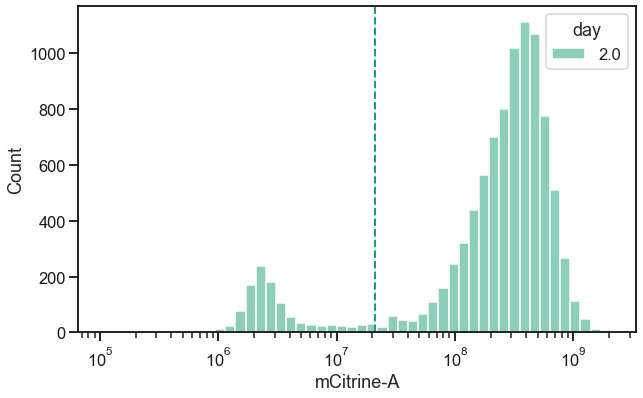

In [8]:
data = df[df['plasmid']==126]
data = data[data['treatment']=='none']
data = data[data['dox']==0]

dl = [2]

g = sns.histplot(
    data = data[data['day'].isin(dl)],
    x = 'mCitrine-A',
    hue = 'day',
    palette = 'Dark2',
    log_scale = True,
    bins = 50
)

for d in dl:
    g.axvline(x = get_citrine_threshold(d), 
              color = list(sns.color_palette('Dark2'))[dl.index(d)], 
              linestyle = '--', lw = 2)

In [9]:
days = [0, 1, 2, 3, 4, 5, 6, 8, 11, 13, 15, 18, 20]
[np.log10(get_citrine_threshold(d)) for d in days]

[array([7.12085161]),
 array([7.28099962]),
 array([7.3356531]),
 array([7.31436447]),
 array([7.17321043]),
 array([7.1543718]),
 array([7.30006847]),
 array([7.26068641]),
 array([6.85379118]),
 array([6.93471639]),
 array([6.9519609]),
 array([6.69401664]),
 array([6.73908663])]

In [10]:
%%time

day_thresh_dict = {d : get_citrine_threshold(d)[0] for d in days}

days = list(df['day'])
cits = list(df['mCitrine-A'])
ons = [c >= day_thresh_dict[d] for c, d in zip(cits, days)]
df['Citrine On'] = ons
df

CPU times: user 42.7 s, sys: 9.78 s, total: 52.5 s
Wall time: 29.6 s


<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,FSC 488/10-A,SSC 488/10-A,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,treatment,P1,mCherry,Citrine On
0,8.317540e+08,219492864.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,14387968.0,85923072.0,59,1.0,none,True,True,True
1,4.958666e+08,180896512.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,104767232.0,66599936.0,59,1.0,none,True,True,True
2,4.226458e+08,101837056.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,26209536.0,61377280.0,59,1.0,none,True,True,True
3,1.038254e+09,372244224.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,365425920.0,376630272.0,59,1.0,none,True,True,True
4,8.091105e+08,349765120.0,0.0,ZIK1 KRAB + Rand Ctrl 89,0.0,180713472.0,1863680.0,59,1.0,none,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42598448,8.930967e+08,375278592.0,20.0,MYB only,1000.0,56984320.0,3530240.0,144,2.0,none,True,True,False
42598449,3.344148e+08,232225536.0,20.0,MYB only,1000.0,19082240.0,2760960.0,144,2.0,none,True,True,False
42598450,6.809889e+08,270729216.0,20.0,MYB only,1000.0,179726848.0,34354432.0,144,2.0,none,True,True,True
42598451,7.104010e+08,199698432.0,20.0,MYB only,1000.0,231051776.0,30063872.0,144,2.0,none,True,True,True


# Compute normalized citrine Offs 

In [11]:
gdf = df.groupby(['plasmid', 'description', 'day', 'dox', 'treatment', 'replicate']).mean()
gdf = gdf.reset_index()
gdf = gdf[['plasmid', 'description', 'day', 'dox', 'treatment', 'replicate', 'Citrine On']]
gdf

,plasmid,description,day,dox,treatment,replicate,Citrine On
0,59,ZIK1 KRAB + Rand Ctrl 89,0.0,0.0,none,1.0,0.875774
1,59,ZIK1 KRAB + Rand Ctrl 89,0.0,0.0,none,2.0,0.901607
2,59,ZIK1 KRAB + Rand Ctrl 89,0.0,1000.0,none,1.0,0.875774
3,59,ZIK1 KRAB + Rand Ctrl 89,0.0,1000.0,none,2.0,0.901607
4,59,ZIK1 KRAB + Rand Ctrl 89,1.0,0.0,none,1.0,0.850087
...,...,...,...,...,...,...,...
2021,217,KRAB only,20.0,1000.0,9-c-RA,2.0,0.692205
2022,217,KRAB only,20.0,1000.0,DMSO,1.0,0.759439
2023,217,KRAB only,20.0,1000.0,DMSO,2.0,0.653005
2024,217,KRAB only,20.0,1000.0,none,1.0,0.769169


In [12]:
pdf = gdf.pivot(
    index = ['plasmid', 'description', 'day', 'treatment', 'replicate'],
    columns = 'dox',
    values = 'Citrine On'
).reset_index()
pdf['0 dox'] = pdf[0]
pdf['1000 dox'] = pdf[1000]
pdf = pdf[['plasmid', 'description', 'day', 'treatment', 'replicate', '0 dox', '1000 dox']]
pdf['norm cit off'] = ((1-pdf['1000 dox']) - (1-pdf['0 dox']))/(pdf['0 dox'])
pdf

dox,plasmid,description,day,treatment,replicate,0 dox,1000 dox,norm cit off
0,59,ZIK1 KRAB + Rand Ctrl 89,0.0,none,1.0,0.875774,0.875774,0.000000
1,59,ZIK1 KRAB + Rand Ctrl 89,0.0,none,2.0,0.901607,0.901607,0.000000
2,59,ZIK1 KRAB + Rand Ctrl 89,1.0,none,1.0,0.850087,0.864358,-0.016788
3,59,ZIK1 KRAB + Rand Ctrl 89,1.0,none,2.0,0.872861,0.868339,0.005181
4,59,ZIK1 KRAB + Rand Ctrl 89,2.0,none,1.0,0.851389,0.303887,0.643069
...,...,...,...,...,...,...,...,...
1009,217,KRAB only,20.0,9-c-RA,2.0,0.663929,0.692205,-0.042589
1010,217,KRAB only,20.0,DMSO,1.0,0.657859,0.759439,-0.154409
1011,217,KRAB only,20.0,DMSO,2.0,0.623661,0.653005,-0.047051
1012,217,KRAB only,20.0,none,1.0,0.889651,0.769169,0.135426


In [13]:
q = pdf[pdf['plasmid']==217]
q = q[q['treatment']=='none']
q

dox,plasmid,description,day,treatment,replicate,0 dox,1000 dox,norm cit off
940,217,KRAB only,0.0,none,1.0,0.860653,0.860653,0.000000
941,217,KRAB only,0.0,none,2.0,0.868142,0.868142,0.000000
946,217,KRAB only,1.0,none,1.0,0.860417,0.844273,0.018763
947,217,KRAB only,1.0,none,2.0,0.854701,0.816692,0.044471
952,217,KRAB only,2.0,none,1.0,0.850877,0.441592,0.481015
953,217,KRAB only,2.0,none,2.0,0.842116,0.336858,0.599986
958,217,KRAB only,3.0,none,1.0,0.842233,0.059128,0.929796
959,217,KRAB only,3.0,none,2.0,0.827699,0.040996,0.950470
964,217,KRAB only,4.0,none,1.0,0.866279,0.006535,0.992456
965,217,KRAB only,4.0,none,2.0,0.846520,0.009929,0.988270


array([0.22065178, 2.58094509, 0.07790856, 1.64568835, 2.        ])

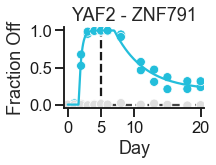

In [38]:
fig, ax = plt.subplots(figsize=(2.5, 1.5))

plasmid = 94

def make_lineplot(ax, plasmid):
    xdf = pdf[pdf['plasmid'].isin([plasmid, 126])]
    xdf = xdf[xdf['treatment']=='none']

    ax.axhline(y = 0, color = '#444444', linestyle = '--', zorder = 0)

    pal = ["#23bedb", "#DEDEDE"] if plasmid != 126 else ["#DEDEDE"]
    if plasmid >= 126:
        pal = pal[::-1]
    
    sns.scatterplot(
        data = xdf,
        x = 'day',
        y = 'norm cit off',
        hue = 'description',
        palette = pal,
        legend = False,
        ax = ax
    )
    
    def s_curve(t, ks, t_lag1):
        return 0.0*(t<t_lag1) + (1-np.exp(-1*ks*(t-t_lag1)))*(t>=t_lag1)
    def r_curve(t, ka, ks, ki, t_lag1, t_lag2):
        y1 = ((ks + ka + ki) - np.sqrt((ks+ka+ki)**2 - 4*ks*ki))/2
        y2 = ((ks + ka + ki) + np.sqrt((ks+ka+ki)**2 - 4*ks*ki))/2
        it = 1 - ((ks*ki)/(y1*(y2-y1)))*np.exp(-y1*(5-t_lag1)) +\
                 ((ks*ki)/(y2*(y2-y1)))*np.exp(-y2*(5-t_lag1))
        st = s_curve(5, ks, t_lag1)
        rt = st - it
        return (t < t_lag2) * st + (t >= t_lag2) * (it + rt*np.exp(-ka*(t-t_lag2)))
    def f_curve(t, ka, ks, ki, t_lag1, t_lag2):
        return (t<5)*s_curve(t, ks, t_lag1) +\
               (t>=5)*r_curve(t-5, ka, ks, ki, t_lag1, t_lag2)
        
    xvalues = list(xdf[xdf['plasmid']==plasmid].dropna(subset=['norm cit off'])['day'])
    yvalues = list(xdf[xdf['plasmid']==plasmid].dropna(subset=['norm cit off'])['norm cit off'])
    popt, pcov = curve_fit(f_curve, xvalues, yvalues,
                           bounds = [[0,   0,  0, 0, 0],
                                     [10, 10, 10, 2, 2]])
    fit_x = np.linspace(0.01, 20, 200)
    fit_y = f_curve(fit_x, *popt) 
    ax.plot(fit_x, fit_y, color = '#23bedb')

    ax.set_xlim(-0.5, 20.5)
    ax.set_xticks([0, 5, 10, 20])
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 0.5, 1])
    
    ax.axvline(x=5, color = 'k', linestyle = '--', zorder = 0)
    
    ax.set_title(plasmid_dict[plasmid])
    
    ax.set_xlabel('Day')
    ax.set_ylabel('Fraction Off')
    #ax.legend(title='', markerscale=1.0)
    
    sns.despine(ax=ax)
    
    return popt
    
make_lineplot(ax, plasmid)

# Making line plots

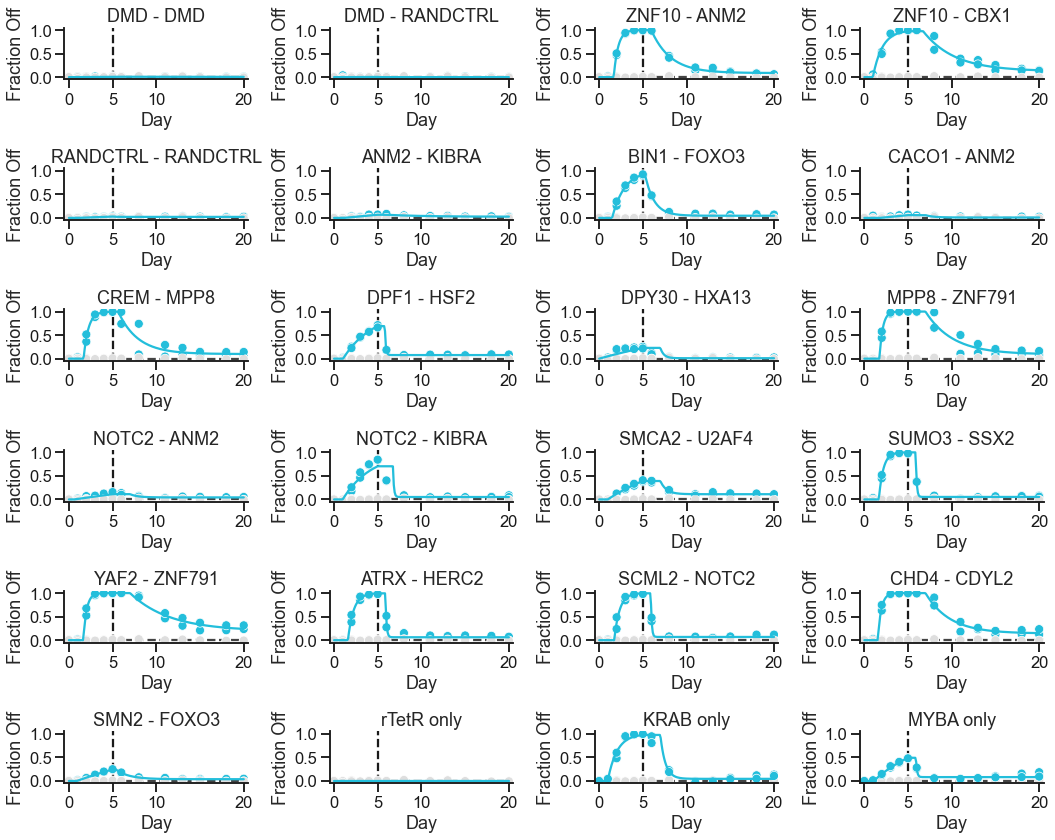

In [143]:
fig, ax = plt.subplots(6, 4, figsize=(15, 12))

plasmid_arr = [[plasmids[4*i + j] for j in range(4)] for i in range(6)]

popt_dict = { p : [] for p in plasmids }

for i in range(len(plasmid_arr)):
    for j in range(len(plasmid_arr[i])):
        popt_dict[plasmid_arr[i][j]] = make_lineplot(ax[i][j], plasmid_arr[i][j])

plt.tight_layout()

fig.savefig('./repressors_d20_omnibus.png', dpi = 300)
fig.savefig('./repressors_d20_omnibus.pdf', bbox_inches = 'tight')

In [46]:
for plasmid in plasmids:
    fig, ax = plt.subplots(figsize=(4, 2))
    
    descr = plasmid_dict[plasmid]
    popt = make_lineplot(ax, plasmid)
    
    fig.savefig('./lineplots/' + descr + ' Silencing.pdf', bbox_inches = 'tight')
    print(descr)
    plt.close(fig)

DMD - DMD
DMD - RANDCTRL
ZNF10 - ANM2
ZNF10 - CBX1
RANDCTRL - RANDCTRL
ANM2 - KIBRA
BIN1 - FOXO3
CACO1 - ANM2
CREM - MPP8
DPF1 - HSF2
DPY30 - HXA13
MPP8 - ZNF791
NOTC2 - ANM2
NOTC2 - KIBRA
SMCA2 - U2AF4
SUMO3 - SSX2
YAF2 - ZNF791
ATRX - HERC2
SCML2 - NOTC2
CHD4 - CDYL2
SMN2 - FOXO3
rTetR only
KRAB only
MYBA only


# Correlation with screen data

In [47]:
qdf = pd.DataFrame.from_dict({
    'plasmid' : plasmids,
    'description' : [plasmid_dict[p] for p in plasmids],
    'ka' : [popt_dict[p][0] for p in plasmids],
    'ks' : [popt_dict[p][1] for p in plasmids],
    'ki' : [popt_dict[p][2] for p in plasmids],
    't_lag1' : [popt_dict[p][3] for p in plasmids],
    't_lag2' : [popt_dict[p][4] for p in plasmids]
})

qdf = qdf[qdf['plasmid'] < 126]

In [48]:
screen_data = pd.read_csv('../../Analysis/20211021b_synergy_with_medians/pairs_baseline_sums_computed.csv')
screen_data

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,act_hit,rep_hit,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,True,False,0.073816,0.216122,-7.111908,NaN,NaN,NaN,1.319031,2.481098
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,True,True,NaN,NaN,NaN,NaN,NaN,NaN,5.250421,0.771599
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,False,True,NaN,NaN,NaN,NaN,NaN,NaN,-3.524457,-1.582110
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,True,True,0.178962,-0.339994,-8.623200,0.178962,-0.339994,-8.623200,4.963128,1.678479
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,False,NaN,5.129901,1.486742,4.050937,NaN,NaN,NaN,-3.418116,-0.057886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Random_control;;;21; --- Silencer_tiles;ENSG00...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.386730,-0.391739,1.123830,NaN,NaN,NaN,-3.335826,-2.120403
8335,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.446548,-0.480109,0.872274,6.952695,6.040754,6.560139,-3.690516,-1.654426
8336,Random_control;;;21; --- Short_nuclear_domain;...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.386730,-0.391739,1.123830,6.952695,6.040754,6.560139,-3.949888,-2.584959
8337,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.446548,-0.480109,0.872274,-1.278913,-0.444267,-5.456627,-2.308094,3.120483


In [49]:
descrs = list(qdf['description'])
splits = [d.split(' ') for d in descrs]
d1s = [s[0] for s in splits]
d2s = [s[2] for s in splits]

qdf['domain1'] = d1s
qdf['domain2'] = d2s

qdf

,plasmid,description,ka,ks,ki,t_lag1,t_lag2,domain1,domain2
0,74,DMD - DMD,0.029716,0.001673,4.504296e-10,5.456374e-14,1.999968e+00,DMD,DMD
1,75,DMD - RANDCTRL,9.922976,0.002334,5.591505e-01,2.000000e+00,1.052526e-11,DMD,RANDCTRL
2,76,ZNF10 - ANM2,0.456620,2.010906,3.849890e-02,1.668233e+00,9.599148e-01,ZNF10,ANM2
3,77,ZNF10 - CBX1,0.278650,0.923237,5.522342e-02,9.834416e-01,1.729433e+00,ZNF10,CBX1
4,78,RANDCTRL - RANDCTRL,2.867482,0.007398,8.881888e+00,9.999915e-01,3.429122e-03,RANDCTRL,RANDCTRL
5,79,ANM2 - KIBRA,0.229217,0.017818,3.541924e-01,1.114588e+00,1.000000e+00,ANM2,KIBRA
6,80,BIN1 - FOXO3,0.961233,0.709989,3.857535e-02,1.487267e+00,2.496860e-01,BIN1,FOXO3
7,81,CACO1 - ANM2,1.115427,0.019010,2.390097e-01,1.786896e+00,2.000000e+00,CACO1,ANM2
8,82,CREM - MPP8,0.444526,1.828836,4.490658e-02,1.685210e+00,6.419971e-01,CREM,MPP8
9,83,DPF1 - HSF2,9.683016,0.296648,7.418157e-01,1.045021e+00,8.170206e-01,DPF1,HSF2


In [50]:
screen_data_d1 = list(screen_data['d1_Gene'])
screen_data_d2 = list(screen_data['d2_Gene'])
screen_data['description'] = [s1 + ' - ' + s2 for s1, s2 in zip(screen_data_d1, screen_data_d2)]
screen_data

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,rep_hit,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5,description
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,False,0.073816,0.216122,-7.111908,NaN,NaN,NaN,1.319031,2.481098,NCOA2 - TET2
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5.250421,0.771599,SERTAD2 - SERTAD2
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,True,NaN,NaN,NaN,NaN,NaN,NaN,-3.524457,-1.582110,HES2 - HES2
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,True,0.178962,-0.339994,-8.623200,0.178962,-0.339994,-8.623200,4.963128,1.678479,ZN473 - ZN473
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,NaN,5.129901,1.486742,4.050937,NaN,NaN,NaN,-3.418116,-0.057886,HERC2 - ADRM1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Random_control;;;21; --- Silencer_tiles;ENSG00...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.386730,-0.391739,1.123830,NaN,NaN,NaN,-3.335826,-2.120403,RANDCTRL - CBX7
8335,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.446548,-0.480109,0.872274,6.952695,6.040754,6.560139,-3.690516,-1.654426,DMD - CBX1
8336,Random_control;;;21; --- Short_nuclear_domain;...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.386730,-0.391739,1.123830,6.952695,6.040754,6.560139,-3.949888,-2.584959,RANDCTRL - CBX1
8337,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.446548,-0.480109,0.872274,-1.278913,-0.444267,-5.456627,-2.308094,3.120483,DMD - CXXC1


In [51]:
mdf = qdf.set_index('description').join(
    screen_data.set_index('description'),
    how = 'left',
    rsuffix = '_screen'
).reset_index()
mdf = mdf[mdf['character'] != 'Control']
mdf = mdf[mdf['description'] != 'DMD - DMD']
mdf = mdf[mdf['description'] != 'DMD - RANDCTRL']
mdf

,description,plasmid,ka,ks,ki,t_lag1,t_lag2,domain1,domain2,pair,...,act_hit,rep_hit,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5
0,ANM2 - KIBRA,79,0.229217,0.017818,0.354192,1.114588e+00,1.000000,ANM2,KIBRA,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45 --...,...,True,False,-1.019050,-0.726941,-5.645672,0.243639,0.312334,-6.707792,-0.120025,3.256295
1,ATRX - HERC2,96,8.542136,1.522976,0.129860,1.595097e+00,0.879580,ATRX,HERC2,Silencer_tiles;ENSG00000085224;242 --- Short_n...,...,False,True,NaN,NaN,NaN,5.129901,1.486742,4.050937,-3.660503,-0.111749
2,BIN1 - FOXO3,80,0.961233,0.709989,0.038575,1.487267e+00,0.249686,BIN1,FOXO3,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63 -...,...,True,True,2.683747,1.246747,1.224325,1.492156,1.681687,-8.389172,1.378309,1.267080
3,CACO1 - ANM2,81,1.115427,0.019010,0.239010,1.786896e+00,2.000000,CACO1,ANM2,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,...,True,False,0.142909,-0.196617,-4.683274,-1.019050,-0.726941,-5.645672,-1.519332,3.219973
4,CHD4 - CDYL2,98,0.361660,2.548712,0.056356,1.542013e+00,2.000000,CHD4,CDYL2,Silencer_tiles;ENSG00000111642;38 --- Short_nu...,...,False,True,4.154102,1.279604,NaN,5.177775,4.974258,3.329373,-4.150471,-4.715207
5,CREM - MPP8,82,0.444526,1.828836,0.044907,1.685210e+00,0.641997,CREM,MPP8,Short_nuclear_domain;CREM_HUMAN;bZIP_1;265;45 ...,...,False,NaN,4.587577,1.876879,2.598693,6.513346,4.151363,5.335222,-4.815247,-1.000123
204,DPF1 - HSF2,83,9.683016,0.296648,0.741816,1.045021e+00,0.817021,DPF1,HSF2,Short_nuclear_domain;DPF1_HUMAN;Requiem_N;34;7...,...,False,False,-0.877510,-1.191838,-2.743392,4.314440,1.798662,NaN,-3.805037,0.828680
205,DPY30 - HXA13,84,2.460441,0.051955,0.103831,2.386840e-13,2.000000,DPY30,HXA13,Short_nuclear_domain;DPY30_HUMAN;Dpy-30;19;41 ...,...,NaN,NaN,-0.750871,-0.694016,-3.696281,3.056264,2.096968,-0.043040,-3.105360,2.806669
206,MPP8 - ZNF791,87,0.321692,2.654754,0.036728,1.732481e+00,2.000000,MPP8,ZNF791,Short_nuclear_domain;MPP8_HUMAN;Chromo;44;50 -...,...,NaN,True,6.513346,4.151363,5.335222,NaN,NaN,NaN,-5.226292,-5.076540
207,NOTC2 - ANM2,90,1.165029,0.027089,0.836176,6.149071e-01,2.000000,NOTC2,ANM2,Short_nuclear_domain;NOTC2_HUMAN;Notch;1440;34...,...,True,False,0.759808,0.077752,-5.258400,-1.019050,-0.726941,-5.645672,-0.888663,3.056657


In [52]:
# manually add back the controls

cdf = qdf[qdf['description'].isin(['DMD - DMD', 'DMD - RANDCTRL', 'RANDCTRL - RANDCTRL'])]
cdf

,plasmid,description,ka,ks,ki,t_lag1,t_lag2,domain1,domain2
0,74,DMD - DMD,0.029716,0.001673,4.504296e-10,5.456374e-14,1.999968e+00,DMD,DMD
1,75,DMD - RANDCTRL,9.922976,0.002334,5.591505e-01,2.000000e+00,1.052526e-11,DMD,RANDCTRL
4,78,RANDCTRL - RANDCTRL,2.867482,0.007398,8.881888e+00,9.999915e-01,3.429122e-03,RANDCTRL,RANDCTRL


In [53]:
cdict = {
    "DMD - DMD" : "DMD_control_tiles;ENSG00000198947;;131; -  DMD_control_tiles;ENSG00000198947;;297;",
    "DMD - RANDCTRL" : "DMD_control_tiles;ENSG00000198947;;297; - Random_control;;;21;",
    "RANDCTRL - RANDCTRL" : "Random_control;;;205; - Random_control;;;410;"
}

cdf['description+'] = [cdict[d] for d in list(cdf['description'])]
cdf

<ipython-input-53-bbf960fe2ee0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,plasmid,description,ka,ks,ki,t_lag1,t_lag2,domain1,domain2,description+
0,74,DMD - DMD,0.029716,0.001673,4.504296e-10,5.456374e-14,1.999968e+00,DMD,DMD,DMD_control_tiles;ENSG00000198947;;131; - DMD...
1,75,DMD - RANDCTRL,9.922976,0.002334,5.591505e-01,2.000000e+00,1.052526e-11,DMD,RANDCTRL,DMD_control_tiles;ENSG00000198947;;297; - Rand...
4,78,RANDCTRL - RANDCTRL,2.867482,0.007398,8.881888e+00,9.999915e-01,3.429122e-03,RANDCTRL,RANDCTRL,Random_control;;;205; - Random_control;;;410;


In [54]:
screen_data_d1 = list(screen_data['domain1'])
screen_data_d2 = list(screen_data['domain2'])
screen_data['description+'] = [s1 + ' - ' + s2 for s1, s2 in zip(screen_data_d1, screen_data_d2)]
screen_data

,pair,type,enrichment_ratio_r1_d2,enrichment_ratio_r1_d5,enrichment_ratio_r2_d2,enrichment_ratio_r2_d5,enrichment_fraction_r1_d2,enrichment_fraction_r1_d5,enrichment_fraction_r2_d2,enrichment_fraction_r2_d5,...,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5,description,description+
0,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...,0 control Pair,3.369442,0.365155,3.719474,-0.000660,0.911776,0.562941,0.929442,0.499886,...,0.073816,0.216122,-7.111908,NaN,NaN,NaN,1.319031,2.481098,NCOA2 - TET2,Short_nuclear_domain;NCOA2_HUMAN;Nuc_rec_co-ac...
1,Silencer_tiles;ENSG00000179833;22 --- Silencer...,0 control Pair,2.414849,-0.758524,3.474812,-0.858615,0.842088,0.371504,0.917477,0.355455,...,NaN,NaN,NaN,NaN,NaN,NaN,5.250421,0.771599,SERTAD2 - SERTAD2,Silencer_tiles;ENSG00000179833;22 - Silencer_t...
2,Silencer_tiles;ENSG00000069812;10 --- Silencer...,0 control Pair,-3.045459,-2.324324,-2.057486,-1.610970,0.108037,0.166436,0.193701,0.246635,...,NaN,NaN,NaN,NaN,NaN,NaN,-3.524457,-1.582110,HES2 - HES2,Silencer_tiles;ENSG00000069812;10 - Silencer_t...
3,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 ---...,0 control Pair,2.151337,-0.643566,3.060479,-0.645404,0.816257,0.390292,0.892962,0.389989,...,0.178962,-0.339994,-8.623200,0.178962,-0.339994,-8.623200,4.963128,1.678479,ZN473 - ZN473,Short_nuclear_domain;ZN473_HUMAN;KRAB;1;41 - S...
4,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...,0 control Pair,-1.554031,-1.183923,-1.379328,-2.532059,0.254042,0.305629,0.277664,0.147406,...,5.129901,1.486742,4.050937,NaN,NaN,NaN,-3.418116,-0.057886,HERC2 - ADRM1,Short_nuclear_domain;HERC2_HUMAN;Cyt-b5;1207;7...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Random_control;;;21; --- Silencer_tiles;ENSG00...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.386730,-0.391739,1.123830,NaN,NaN,NaN,-3.335826,-2.120403,RANDCTRL - CBX7,Random_control;;;21; - Silencer_tiles;ENSG0000...
8335,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.446548,-0.480109,0.872274,6.952695,6.040754,6.560139,-3.690516,-1.654426,DMD - CBX1,DMD_control_tiles;ENSG00000198947;;255; - Shor...
8336,Random_control;;;21; --- Short_nuclear_domain;...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.386730,-0.391739,1.123830,6.952695,6.040754,6.560139,-3.949888,-2.584959,RANDCTRL - CBX1,Random_control;;;21; - Short_nuclear_domain;CB...
8337,DMD_control_tiles;ENSG00000198947;;255; --- Sh...,1 control Pair,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.446548,-0.480109,0.872274,-1.278913,-0.444267,-5.456627,-2.308094,3.120483,DMD - CXXC1,DMD_control_tiles;ENSG00000198947;;255; - Shor...


In [55]:
ccdf = cdf.set_index('description+').join(
    screen_data.set_index('description+'),
    how = 'left',
    rsuffix = '_screen'
).reset_index()
ccdf = ccdf.drop(['description+'], axis=1)
ccdf

,plasmid,description,ka,ks,ki,t_lag1,t_lag2,domain1,domain2,pair,...,rep_hit,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5,description_screen
0,74,DMD - DMD,0.029716,0.001673,4.504296e-10,5.456374e-14,1.999968e+00,DMD,DMD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,75,DMD - RANDCTRL,9.922976,0.002334,5.591505e-01,2.000000e+00,1.052526e-11,DMD,RANDCTRL,DMD_control_tiles;ENSG00000198947;;297; --- Ra...,...,False,-0.481389,-0.300723,0.880544,-0.386730,-0.391739,1.123830,-2.639928,1.412227,DMD - RANDCTRL
2,78,RANDCTRL - RANDCTRL,2.867482,0.007398,8.881888e+00,9.999915e-01,3.429122e-03,RANDCTRL,RANDCTRL,Random_control;;;205; --- Random_control;;;410;,...,False,-0.213846,-0.499577,0.965604,-0.705059,-0.498968,0.924894,-2.852087,0.751467,RANDCTRL - RANDCTRL


In [56]:
zdf = pd.concat([mdf, ccdf])
zdf.sort_values(by='plasmid')

,description,plasmid,ka,ks,ki,t_lag1,t_lag2,domain1,domain2,pair,...,rep_hit,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5,description_screen
0,DMD - DMD,74,0.029716,0.001673,4.504296e-10,5.456374e-14,1.999968e+00,DMD,DMD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DMD - RANDCTRL,75,9.922976,0.002334,5.591505e-01,2.000000e+00,1.052526e-11,DMD,RANDCTRL,DMD_control_tiles;ENSG00000198947;;297; --- Ra...,...,False,-0.481389,-0.300723,0.880544,-0.386730,-0.391739,1.123830,-2.639928,1.412227,DMD - RANDCTRL
313,ZNF10 - ANM2,76,0.456620,2.010906,3.849890e-02,1.668233e+00,9.599148e-01,ZNF10,ANM2,Human_KRAB_variant;P21506;146 --- Short_nuclea...,...,True,NaN,NaN,NaN,-1.019050,-0.726941,-5.645672,-2.967010,-1.143555,NaN
314,ZNF10 - CBX1,77,0.278650,0.923237,5.522342e-02,9.834416e-01,1.729433e+00,ZNF10,CBX1,Human_KRAB_variant;P21506;146 --- Short_nuclea...,...,True,NaN,NaN,NaN,6.952695,6.040754,6.560139,-5.050679,-5.470237,NaN
2,RANDCTRL - RANDCTRL,78,2.867482,0.007398,8.881888e+00,9.999915e-01,3.429122e-03,RANDCTRL,RANDCTRL,Random_control;;;205; --- Random_control;;;410;,...,False,-0.213846,-0.499577,0.965604,-0.705059,-0.498968,0.924894,-2.852087,0.751467,RANDCTRL - RANDCTRL
0,ANM2 - KIBRA,79,0.229217,0.017818,3.541924e-01,1.114588e+00,1.000000e+00,ANM2,KIBRA,Short_nuclear_domain;ANM2_HUMAN;SH3_1;18;45 --...,...,False,-1.019050,-0.726941,-5.645672,0.243639,0.312334,-6.707792,-0.120025,3.256295,NaN
2,BIN1 - FOXO3,80,0.961233,0.709989,3.857535e-02,1.487267e+00,2.496860e-01,BIN1,FOXO3,Short_nuclear_domain;BIN1_HUMAN;SH3_9;513;63 -...,...,True,2.683747,1.246747,1.224325,1.492156,1.681687,-8.389172,1.378309,1.267080,NaN
3,CACO1 - ANM2,81,1.115427,0.019010,2.390097e-01,1.786896e+00,2.000000e+00,CACO1,ANM2,Short_nuclear_domain;CACO1_HUMAN;Zn-C2H2_12;61...,...,False,0.142909,-0.196617,-4.683274,-1.019050,-0.726941,-5.645672,-1.519332,3.219973,NaN
5,CREM - MPP8,82,0.444526,1.828836,4.490658e-02,1.685210e+00,6.419971e-01,CREM,MPP8,Short_nuclear_domain;CREM_HUMAN;bZIP_1;265;45 ...,...,NaN,4.587577,1.876879,2.598693,6.513346,4.151363,5.335222,-4.815247,-1.000123,NaN
204,DPF1 - HSF2,83,9.683016,0.296648,7.418157e-01,1.045021e+00,8.170206e-01,DPF1,HSF2,Short_nuclear_domain;DPF1_HUMAN;Requiem_N;34;7...,...,False,-0.877510,-1.191838,-2.743392,4.314440,1.798662,NaN,-3.805037,0.828680,NaN


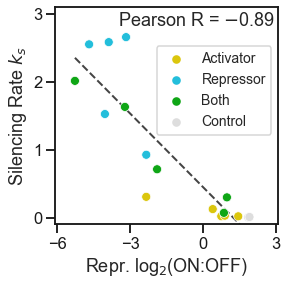

In [216]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.set_xlim(-6.1, 3.1)
ax.set_xticks([-6, -3, 0, 3])
ax.set_ylim(-0.1, 3.1)
ax.set_yticks([0, 1, 2, 3])

x = list(zdf['avg_enrichment_d5'])
y = list(zdf['ks'])

pdict = {'Activator' : '#dbc60d', 
         'Repressor' : '#23bedb', 
         'Both' : "#0fa616", 
         'Control' : "#dddddd",
         np.nan : '#dddddd'}
cols = [pdict[t] for t in list(zdf['character'])]

sns.regplot(data = zdf,
            x='avg_enrichment_d5', y='ks', ci=None, marker = None, scatter = False,
            line_kws = {'linestyle' : '--', 'lw' : 2, 'color' : '#444444', 'zorder' : -10},
            ax=ax)

sns.scatterplot(
    data = zdf, x = 'avg_enrichment_d5', y = 'ks', hue = 'character',
    palette = ['#dbc60d', '#23bedb', "#0fa616", "#dddddd"],
    marker = 'o', facecolor = 'none', ax=ax
)

ldf = zdf.dropna(subset=['character', 'avg_enrichment_d5', 'ks'])
r, p = st.pearsonr(ldf['avg_enrichment_d5'], ldf['ks'])

ax.set_xlabel('Repr. log$_2$(ON:OFF)')
ax.set_ylabel('Silencing Rate $k_s$')
l = ax.legend(prop = {'size' : 14}, bbox_to_anchor = (0.425, 0.85))
for lh in l.legendHandles:
    lh._sizes = [50]

ax.text(-3.5, 2.825, "Pearson R = $-${:.2f}".format(np.abs(r)))

fig.savefig('./repressor_sil_correlation.pdf', bbox_inches = 'tight')
fig.savefig('./repressor_sil_correlation.png', dpi = 300)

# Correlating with Activation Data

In [138]:
act_data = pd.read_csv('../2021.11.15_activation_round1/activation_data.csv')
print(list(act_data.columns))
act_data

['description', 'plasmid', 'day', 'dox', 'replicate', 'FSC 488/10-A', 'SSC 488/10-A', 'mCherry-A', 'mCitrine-A', 'P1', 'mCherry', 'Citrine On', 'domain1', 'domain2', 'pair', 'type', 'enrichment_ratio_r1_d2', 'enrichment_ratio_r1_d5', 'enrichment_ratio_r1_d10', 'enrichment_ratio_r2_d2', 'enrichment_ratio_r2_d5', 'enrichment_ratio_r2_d10', 'enrichment_fraction_r1_d2', 'enrichment_fraction_r1_d5', 'enrichment_fraction_r1_d10', 'enrichment_fraction_r2_d2', 'enrichment_fraction_r2_d5', 'enrichment_fraction_r2_d10', 'bound_r1_d2', 'bound_r1_d5', 'bound_r1_d10', 'bound_r2_d2', 'bound_r2_d5', 'bound_r2_d10', 'norm_bound_r1_d2', 'norm_bound_r1_d5', 'norm_bound_r1_d10', 'norm_bound_r2_d2', 'norm_bound_r2_d5', 'norm_bound_r2_d10', 'norm_unbound_r1_d2', 'norm_unbound_r1_d5', 'norm_unbound_r1_d10', 'norm_unbound_r2_d2', 'norm_unbound_r2_d5', 'norm_unbound_r2_d10', 'avg_enrichment_d2', 'avg_enrichment_d5', 'avg_enrichment_d10', 'domain1_screen', 'domain2_screen', 'd1_Gene', 'd1_Pathway', 'd1_Descrip

,description,plasmid,day,dox,replicate,FSC 488/10-A,SSC 488/10-A,mCherry-A,mCitrine-A,P1,...,rep_hit,d1_prior_avg_d5,d1_prior_avg_dm,d1_prior_avg_d2,d2_prior_avg_d5,d2_prior_avg_dm,d2_prior_avg_d2,baseline_sum_d2,baseline_sum_d5,description_screen
0,ANM2 - KIBRA,79,2.0,1000.0,1.5,7.854868e+08,2.173589e+08,2.280779e+08,2.585994e+08,1.0,...,False,-1.019050,-0.726941,-5.645672,0.243639,0.312334,-6.707792,-0.145996,3.174879,NaN
1,ATRX - HERC2,96,2.0,1000.0,1.5,7.822469e+08,2.094257e+08,2.252698e+08,1.972691e+06,1.0,...,True,NaN,NaN,NaN,5.129901,1.486742,4.050937,-3.686474,-0.230680,NaN
2,BIN1 - FOXO3,80,2.0,1000.0,1.5,7.326128e+08,2.039081e+08,1.425160e+08,5.691427e+07,1.0,...,True,2.683747,1.246747,1.224325,1.492156,1.681687,-8.389172,1.352338,1.236541,NaN
3,CACO1 - ANM2,81,2.0,1000.0,1.5,7.438811e+08,2.054264e+08,1.788837e+08,2.661532e+08,1.0,...,False,0.142909,-0.196617,-4.683274,-1.019050,-0.726941,-5.645672,-1.545303,3.142817,NaN
4,CHD4 - CDYL2,98,2.0,1000.0,1.5,7.578148e+08,2.072625e+08,1.819361e+08,1.896662e+06,1.0,...,True,4.154102,1.279604,NaN,5.177775,4.974258,3.329373,-4.176443,-4.738963,NaN
5,CREM - MPP8,82,2.0,1000.0,1.5,7.519720e+08,2.048163e+08,1.990641e+08,1.885947e+06,1.0,...,True,4.587577,1.876879,2.598693,6.513346,4.151363,5.335222,-4.841218,-2.697996,NaN
6,DPF1 - HSF2,83,2.0,1000.0,1.5,7.358323e+08,2.059303e+08,1.582734e+08,1.979073e+06,1.0,...,False,-0.877510,-1.191838,-2.743392,4.314440,1.798662,NaN,-3.831008,0.835209,NaN
7,DPY30 - HXA13,84,2.0,1000.0,1.5,7.306644e+08,2.029543e+08,1.412203e+08,1.965050e+06,1.0,...,NaN,-0.750871,-0.694016,-3.696281,3.056264,2.096968,-0.043040,-3.131331,2.734139,NaN
8,MPP8 - ZNF791,87,2.0,1000.0,1.5,7.667548e+08,2.105313e+08,2.291278e+08,1.888433e+06,1.0,...,True,6.513346,4.151363,5.335222,NaN,NaN,NaN,-5.252263,-4.962111,NaN
9,NOTC2 - ANM2,90,2.0,1000.0,1.5,7.524635e+08,2.084351e+08,1.673833e+08,3.013375e+08,1.0,...,False,0.759808,0.077752,-5.258400,-1.019050,-0.726941,-5.645672,-0.914634,2.972803,NaN


In [139]:
vdf = zdf.set_index('description').join(
    act_data.set_index('description'),
    on = 'description',
    how = 'left',
    rsuffix = '_act'
).reset_index()
vdf = vdf[['description', 'plasmid', 
           'ka', 'ks', 'ki', 't_lag1', 't_lag2',
           'Citrine On', 'character']]
vdf['character'] = list(vdf['character'])[0:18] + ['Control'] + list(vdf['character'])[19:]
vdf

,description,plasmid,ka,ks,ki,t_lag1,t_lag2,Citrine On,character
0,ANM2 - KIBRA,79,0.229217,0.017818,3.541924e-01,1.114588e+00,1.000000e+00,0.962426,Activator
1,ATRX - HERC2,96,8.542136,1.522976,1.298605e-01,1.595097e+00,8.795804e-01,0.011904,Repressor
2,BIN1 - FOXO3,80,0.961233,0.709989,3.857535e-02,1.487267e+00,2.496860e-01,0.691774,Both
3,CACO1 - ANM2,81,1.115427,0.019010,2.390097e-01,1.786896e+00,2.000000e+00,0.948644,Activator
4,CHD4 - CDYL2,98,0.361660,2.548712,5.635578e-02,1.542013e+00,2.000000e+00,0.009700,Repressor
5,CREM - MPP8,82,0.444526,1.828836,4.490658e-02,1.685210e+00,6.419971e-01,0.009251,Repressor
6,DPF1 - HSF2,83,9.683016,0.296648,7.418157e-01,1.045021e+00,8.170206e-01,0.028202,Both
7,DPY30 - HXA13,84,2.460441,0.051955,1.038310e-01,2.386840e-13,2.000000e+00,0.017484,Both
8,MPP8 - ZNF791,87,0.321692,2.654754,3.672841e-02,1.732481e+00,2.000000e+00,0.010100,Repressor
9,NOTC2 - ANM2,90,1.165029,0.027089,8.361763e-01,6.149071e-01,2.000000e+00,0.939169,Activator


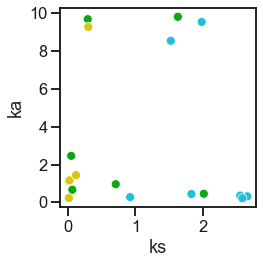

In [141]:
fig, ax = plt.subplots(figsize=(4,4))

qdf = vdf[vdf['character']!='Control']

sns.scatterplot(
    data = qdf,
    x = 'ks',
    y = 'ka',
    hue = 'character',
    palette = ['#dbc60d', '#23bedb', "#0fa616"], #"#dddddd"],
    ax = ax,
    legend = None
)
#ax.legend(None)
#ax.legend(title='', markerscale=1.0)#, bbox_to_anchor = (1.7, 1.1))
# ax.set_xlim(-0.05, 1.05)
# ax.set_ylim(-0.2, 4.5)

# ax.set_xlabel('Day 2 Fraction On')
# ax.set_ylabel('Silencing Rate $k_s$')

plt.tight_layout()
#fig.savefig('./activation_ks_correlation.pdf', bbox_inches = 'tight')

# Some Distributions

In [31]:
bfdf = df[df['plasmid'] == 217]
bfdf = bfdf[bfdf['day'].isin([0, 5, 11, 15])]
bfdf

,FSC 488/10-A,SSC 488/10-A,day,description,dox,mCherry-A,mCitrine-A,plasmid,replicate,treatment,P1,mCherry,Citrine On
440585,8.289746e+08,2.658726e+08,0.0,KRAB only,0.0,2.147483e+09,91726592.0,217,1.0,none,True,True,True
440586,8.764634e+08,2.671273e+08,0.0,KRAB only,0.0,6.812877e+08,94087168.0,217,1.0,none,True,True,True
440587,1.429986e+09,5.200602e+08,0.0,KRAB only,0.0,8.743355e+08,712663808.0,217,1.0,none,True,True,True
440588,7.038326e+08,2.901028e+08,0.0,KRAB only,0.0,4.961544e+08,477287168.0,217,1.0,none,True,True,True
440589,9.541020e+08,3.421233e+08,0.0,KRAB only,0.0,1.815310e+09,533527040.0,217,1.0,none,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25382208,7.193459e+08,1.763131e+08,15.0,KRAB only,1000.0,5.923584e+07,77441536.0,217,2.0,9-c-RA,True,True,True
25382209,8.669640e+08,2.620449e+08,15.0,KRAB only,1000.0,3.528020e+08,2447616.0,217,2.0,9-c-RA,True,True,False
25382210,7.833464e+08,1.437818e+09,15.0,KRAB only,1000.0,3.423667e+07,37367040.0,217,2.0,9-c-RA,True,True,True
25382211,7.112028e+08,3.415882e+08,15.0,KRAB only,1000.0,2.097114e+08,265804032.0,217,2.0,9-c-RA,True,True,True


In [32]:
cp = sns.color_palette('rocket')
#cp = np.array(cp)
cpl = [list(x) for x in list(cp)]
cpl = np.array(cpl)
cpl[1, :]
cpl
cpx = cpl[[0, 2, 3, 5]]
cpx

array([[0.20973515, 0.09747934, 0.24238489],
       [0.67824099, 0.09192342, 0.3504148 ],
       [0.8833417 , 0.19830556, 0.26014181],
       [0.96516917, 0.70776351, 0.5606593 ]])

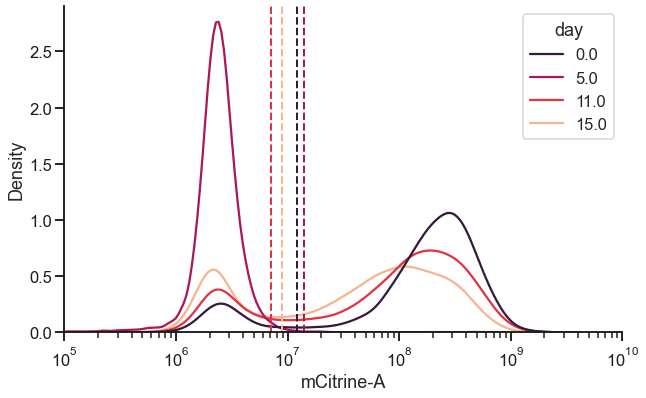

In [33]:
g = sns.kdeplot(
    data = bfdf[bfdf['dox']==1000],
    x = 'mCitrine-A',
    hue = 'day',
    palette = list(cpx),
    log_scale = True,
    common_norm = False
)

g.set_yticks([])
g.set_xlim([1e5, 1e10])
g.set_yscale('linear')

for d in [0, 5, 11, 15]:
    g.axvline(x = get_citrine_threshold(d), 
              color = list(cpx)[[0,5,11,15].index(d)], 
              linestyle = '--', lw = 2)
sns.despine()